In [1]:
from src.models import Exponential_Model
from src.criterion import RightCensorWrapper,RankingWrapper,RHC_Ranking_Wrapper
from src.load_data import load_datasets,load_dataframe
from src.utils import train_robust,lower_bound
from src.visualizations import *
from src.metrics import concordance,ibs,rhc_neg_logll

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter,CoxPHFitter,ExponentialFitter,WeibullAFTFitter
from lifelines.utils import concordance_index

from auto_LiRPA import BoundedModule, BoundedTensor

import argparse

from tqdm import tqdm
import pandas as pd
import numpy as np
from copy import deepcopy
import random
import os

# set seeds for random!!!
torch.manual_seed(123)
random.seed(123)
np.random.seed(123)
torch.cuda.manual_seed_all(123)

/Users/stefanomaxenti/.pyenv/versions/3.9.13/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/stefanomaxenti/Library/CloudStorage/OneDrive-NortheasternUniversity/PhD - Northeastern University/Courses/EECE7398 21010 ST - Verifiable Machine Learning/_Project/EECE7398_Final_Project/src/visualizations.py:150: DeprecationWarning: invalid escape sequence \m
  axes[1].set_title("$\mu$={:.4f} $\sigma^2$={:.4f}".format(lambda_robust.mean(),lambda_robust.var()))
/Users/stefanomaxenti/Library/CloudStorage/OneDrive-NortheasternUniversity/PhD - Northeastern University/Courses/EECE7398 21010 ST - Verifiable Machine Learning/_Project/EECE7398_Final_Project/src/visualizations.py:153: DeprecationWarning: invalid escape sequence \l
  axes[0].set_title("$\lambda$ Fragile")


In [2]:
def loss_wrapper(loss_wrapper):
    if loss_wrapper == "rank":
        return RankingWrapper
    elif loss_wrapper == "rhc":
        return RightCensorWrapper
    elif loss_wrapper == "rhc_rank":
        return RHC_Ranking_Wrapper
    else:
        raise Exception("not valid wrapper choice")

In [3]:
dataset = "TRACE"
eps = 0.5
lr = 1e-3
sigma = 1.0
weight = 1.0
num_epochs = 150
batch_size = 128
smooth_window = 5
hidden_dims = [50, 50]
seed = 123


scheduler_name = "SmoothedScheduler"
scheduler_opts = "start=100, length=10"
loss_wrapper = "rhc_rank"
norm = np.inf
pareto = "0.1 0.9"

In [4]:
df_train,df_val,df_test = load_dataframe(ds_name=dataset,drop_first=True)
dataset_train, dataset_val, dataset_test = load_datasets(dataset, test_size=0.2)
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1

# load the datasets
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# set the dataloader mean and std ... not needed right now
dataloader_train.mean = dataloader_val.mean = dataloader_test.mean = dataset_train.mean
dataloader_train.std = dataloader_val.mean = dataloader_test.std = dataset_train.std

print(f"The train dataset shape {dataset_train.tensors[0].shape}")
print(f"The val dataset shape {dataset_val.tensors[0].shape}")
print(f"The test dataset shape {dataset_test.tensors[0].shape}")

# initialize the Neural Network models (exponential models)
clf_robust = Exponential_Model(input_dim=input_dims,hidden_layers=hidden_dims)
clf_fragile = Exponential_Model(input_dim=input_dims,hidden_layers=hidden_dims)
clf_fragile.load_state_dict(deepcopy(clf_robust.state_dict()))

The train dataset shape torch.Size([1126, 10])
The val dataset shape torch.Size([376, 10])
The test dataset shape torch.Size([376, 10])


<All keys matched successfully>

In [5]:
epsilons = [2.0,1, .8, 0.7, .6, 0.5, 0.1, 0.07, 0.05, 0]
eps_random, ci_random= concordance(clf_robust, dataloader_train, epsilons)
df_ci_random = pd.DataFrame({"RANDOM CI":ci_random},index=eps_random)
print("Train Concordance Index RANDOM \n",df_ci_random)

eps_robust, ibs_random = ibs(clf_robust, dataloader_train, dataloader_test,epsilons)
df_ibs_random = pd.DataFrame({"RANDOM IBS":ibs_random},index=eps_robust)
print("Test Integrated Brier Score RANDOM \n",df_ibs_random)

eps_robust, neg_ll_random = rhc_neg_logll(clf_robust, dataloader_train,epsilons)
df_negll_random = pd.DataFrame({"RANDOM Neg LL":neg_ll_random},index=eps_robust)
print("Train Neg LL RANDOM \n",df_negll_random)

Train Concordance Index RANDOM 
       RANDOM CI
2.00   0.384630
1.00   0.429043
0.80   0.418518
0.70   0.418002
0.60   0.418713
0.50   0.416187
0.10   0.436319
0.07   0.439198
0.05   0.441321
0.00   0.447140
Test Integrated Brier Score RANDOM 
       RANDOM IBS
2.00    0.645103
1.00    0.614857
0.80    0.597985
0.70    0.586889
0.60    0.574042
0.50    0.559836
0.10    0.509647
0.07    0.508134
0.05    0.507290
0.00    0.505639
Train Neg LL RANDOM 
       RANDOM Neg LL
2.00  193529.421875
1.00   22213.562500
0.80   14474.747070
0.70   11725.623047
0.60    9571.118164
0.50    7937.694336
0.10    4954.623047
0.07    4901.676758
0.05    4872.600098
0.00    4816.978516


In [11]:
import torch
from tqdm import tqdm
import time
import time
from auto_LiRPA import BoundedModule, BoundedTensor
from auto_LiRPA.perturbations import *
from auto_LiRPA.utils import MultiAverageMeter
from auto_LiRPA.eps_scheduler import LinearScheduler, AdaptiveScheduler, SmoothedScheduler, FixedScheduler
import random
import numpy as np
from copy import deepcopy
from torch import optim

from src.criterion import RightCensorWrapper,ranking_loss

from csv import writer
from csv import reader

def right_censored(rate,t,event, printing=False):
    log_exact = torch.log(rate) - (t*rate)
    log_right = -(rate*t)
    if printing:
        print(log_exact, log_right)
    return (-event*log_exact - (1-event)*log_right).sum()


def pgd(model, original_data, t, event, attack_magnitude, criterion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    original_data.to(device)
    perturbed_data = original_data
    loss = criterion
    original_images = perturbed_data.data
    
    alpha = attack_magnitude
    iters = 10
    
    for i in range(iters) : 
        model.zero_grad()

        perturbed_data.requires_grad = True
        
        #outputs = model((perturbed_data))
        cost = loss(model(perturbed_data), t, event).to(device)
        cost.backward()
        sign_gradient = perturbed_data.grad.sign()
        perturbed_data = perturbed_data.detach()
        
        perturbed_data = perturbed_data+ alpha*sign_gradient

        difference = torch.clip(perturbed_data - original_images, min=-attack_magnitude, max=attack_magnitude)
        perturbed_data = original_images+difference

    model.zero_grad()
    return perturbed_data
    

# TODO: customize for the right censored data analysis or exact time data analysis
def train(model,dataloader_train,optimizer,criterion,epochs,print_every=25, robust=False, save_pth=None,):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

    train_loss = torch.zeros((epochs,))

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader_train, 0):
            # get the inputs; data is a list of [inputs, labels]
            xi,ti,yi = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            #print("xi:", xi)
            rate = model(xi)
            loss1 = criterion(rate,ti,yi)
            #print("pgd_r:", pgd_r)
            if robust:
                #print("rob")
                pgd_r = model(pgd(model, xi, ti, yi, 0.5, criterion))
                loss2 = criterion( pgd_r , ti, yi, printing=False)
                loss = 0.9*loss1 + 0.1*loss2
            else:
                #print("non rob")
                loss = loss1
            #print(loss1, loss2)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            #print(running_loss)

        if (epoch+1) % print_every == 0:
            print("Epoch {:d}, LL={:.3f}".format(epoch+1,running_loss))
        train_loss[epoch] = running_loss

    print('Finished Training')
    if save_pth is not None:
        torch.save(model.state_dict(),save_pth)

    return torch.arange(epochs),train_loss

In [16]:
import time

clf = Exponential_Model(input_dim=input_dims,hidden_layers=hidden_dims,output_dim=output_dim)
clf_robust = Exponential_Model(input_dim=input_dims,hidden_layers=hidden_dims,output_dim=output_dim)
clf_robust.load_state_dict(deepcopy(clf.state_dict()))

optimizer = Adam(clf.parameters(),lr=lr)
criterion = right_censored
print("Non robust")
epochs1,train_loss1 = train(model=clf,
                            dataloader_train=dataloader_train,
                            optimizer=optimizer,
                            criterion=criterion,
                            print_every=1,
                            epochs=2000)

print("Robust")
optimizer = Adam(clf_robust.parameters(),lr=lr)
criterion = right_censored
epochs2,train_loss2 = train(model=clf_robust, 
                            dataloader_train=dataloader_train,
                            optimizer=optimizer,
                            criterion=criterion,
                            print_every=1,
                            epochs=2000,
                            robust=True)

Non robust
Epoch 1, LL=4370.925
Epoch 2, LL=3551.451
Epoch 3, LL=2924.934
Epoch 4, LL=2423.942
Epoch 5, LL=2089.475
Epoch 6, LL=1882.671
Epoch 7, LL=1771.157
Epoch 8, LL=1714.353
Epoch 9, LL=1679.118
Epoch 10, LL=1655.635
Epoch 11, LL=1642.481
Epoch 12, LL=1632.959
Epoch 13, LL=1626.638
Epoch 14, LL=1619.549
Epoch 15, LL=1614.072
Epoch 16, LL=1609.726
Epoch 17, LL=1604.997
Epoch 18, LL=1601.229
Epoch 19, LL=1598.178
Epoch 20, LL=1596.283
Epoch 21, LL=1594.008
Epoch 22, LL=1592.125
Epoch 23, LL=1589.032
Epoch 24, LL=1588.117
Epoch 25, LL=1585.607
Epoch 26, LL=1583.767
Epoch 27, LL=1582.767
Epoch 28, LL=1582.113
Epoch 29, LL=1580.231
Epoch 30, LL=1578.643
Epoch 31, LL=1579.143
Epoch 32, LL=1576.442
Epoch 33, LL=1575.782
Epoch 34, LL=1574.211
Epoch 35, LL=1573.181
Epoch 36, LL=1573.080
Epoch 37, LL=1572.381
Epoch 38, LL=1570.796
Epoch 39, LL=1569.939
Epoch 40, LL=1568.906
Epoch 41, LL=1568.646
Epoch 42, LL=1568.133
Epoch 43, LL=1567.007
Epoch 44, LL=1565.003
Epoch 45, LL=1564.413
Epoch 46

KeyboardInterrupt: 

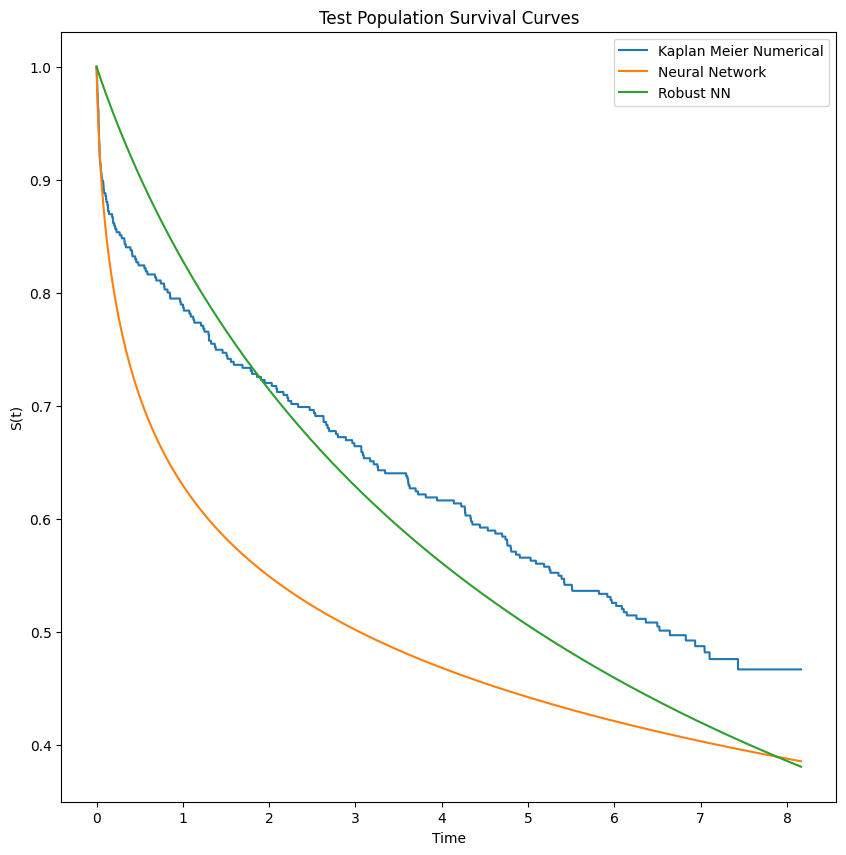

In [13]:
X_test,T_test,E_test = dataloader_test.dataset.tensors
X_test_robust = pgd(clf, X_test, T_test, E_test, 0.5, criterion)

t = torch.linspace(0,T_test.max(),10000)

St_given_x = clf.survival_qdf(X_test_robust,t).detach()
St_given_x_non_robust = clf.survival_qdf(X_test_robust,t).detach()
St_given_x_robust = clf_robust.survival_qdf(X_test_robust,t).detach()

kmf = KaplanMeierFitter()
kmf.fit(durations=T_test,event_observed=E_test)
St_kmf = kSt_kmf = kmf.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_given_x.mean(0))
plt.plot(t,St_given_x_robust.mean(0))
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical","Neural Network", "Robust NN"])
plt.title("Test Population Survival Curves")
plt.show()

<Figure size 1000x1000 with 0 Axes>

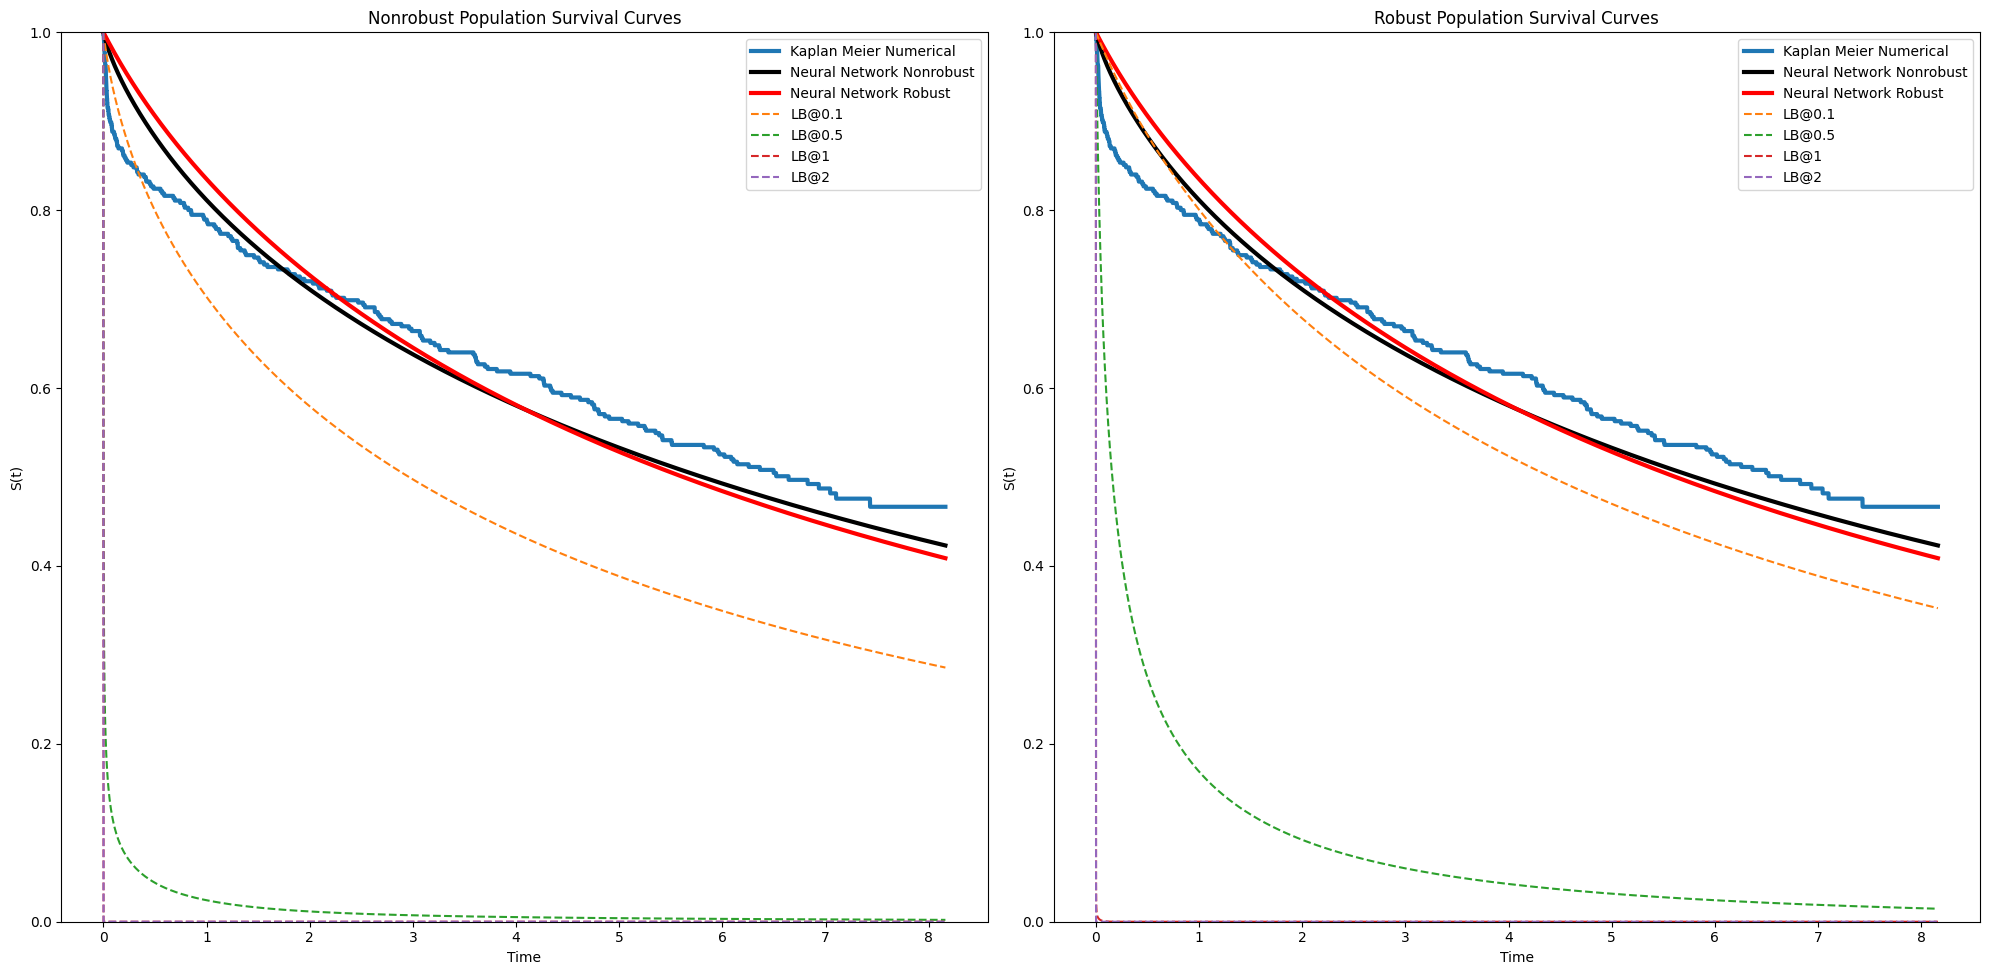

In [14]:
visualize_population_curves_attacked(clf,clf_robust,dataloader_test,epsilons=[0.1, 0.5,  1, 2],suptitle="",img_path="")

In [10]:
# ======================= Benchmarks ========================== #
epsilons = [2.0,1, .8, 0.7, .6, 0.5, 0.1, 0.07, 0.05, 0]
eps_robust, ci_robust = concordance(clf_robust, dataloader_train, epsilons)
_, ci_fragile = concordance(clf, dataloader_train, epsilons)
df_ci_train = pd.DataFrame({"Robust CI":ci_robust,"Non Robust CI":ci_fragile},index=eps_robust)
print("Train Concordance Index \n",df_ci_train)

eps_robust, ci_robust = concordance(clf_robust, dataloader_test, epsilons)
_, ci_fragile = concordance(clf, dataloader_test, epsilons)
df_ci_test = pd.DataFrame({"Robust CI":ci_robust,"Non Robust CI":ci_fragile},index=eps_robust)
print("Test Concordance Index \n",df_ci_test)


eps_robust, ibs_robust = ibs(clf_robust, dataloader_train, dataloader_test,epsilons)
_, ibs_fragile = ibs(clf, dataloader_train,dataloader_test, epsilons)
df_ibs_test = pd.DataFrame({"Robust IBS":ibs_robust,"Non Robust IBS":ibs_fragile},index=eps_robust)
print("Test Integrated Brier Score \n",df_ibs_test)

eps_robust, neg_ll_robust = rhc_neg_logll(clf_robust, dataloader_test,epsilons)
_, neg_ll_fragile = rhc_neg_logll(clf, dataloader_test, epsilons)
df_neg_ll_test = pd.DataFrame({"Robust NegLL":neg_ll_robust,"Non Robust NegLL":neg_ll_fragile},index=eps_robust)
print("Test NLL \n",df_neg_ll_test)

/Users/stefanomaxenti/Library/CloudStorage/OneDrive-NortheasternUniversity/PhD - Northeastern University/Courses/EECE7398 21010 ST - Verifiable Machine Learning/_Project/EECE7398_Final_Project/src/metrics.py:18: RuntimeWarning: All-NaN axis encountered
  ub[ub.isnan()] = (np.nanmax(ub) + torch.tensor(np.random.randn(ub.isnan().sum(), 1)).ravel()).type(


Train Concordance Index 
       Robust CI  Non Robust CI
2.00        NaN            NaN
1.00        NaN            NaN
0.80   0.489651            NaN
0.70   0.458849       0.500000
0.60   0.446875       0.492754
0.50   0.463867       0.505409
0.10   0.770991       0.678717
0.07   0.797689       0.731704
0.05   0.812378       0.772040
0.00   0.832877       0.843306


/Users/stefanomaxenti/Library/CloudStorage/OneDrive-NortheasternUniversity/PhD - Northeastern University/Courses/EECE7398 21010 ST - Verifiable Machine Learning/_Project/EECE7398_Final_Project/src/metrics.py:18: RuntimeWarning: All-NaN axis encountered
  ub[ub.isnan()] = (np.nanmax(ub) + torch.tensor(np.random.randn(ub.isnan().sum(), 1)).ravel()).type(


Test Concordance Index 
       Robust CI  Non Robust CI
2.00        NaN            NaN
1.00        NaN            NaN
0.80   0.480556            NaN
0.70   0.423730            NaN
0.60   0.427569       0.488604
0.50   0.448066       0.474279
0.10   0.686898       0.634243
0.07   0.683049       0.645563
0.05   0.679901       0.655119
0.00   0.684187       0.677209


/Users/stefanomaxenti/Library/CloudStorage/OneDrive-NortheasternUniversity/PhD - Northeastern University/Courses/EECE7398 21010 ST - Verifiable Machine Learning/_Project/EECE7398_Final_Project/src/metrics.py:77: RuntimeWarning: All-NaN axis encountered
  ub[ub.isnan()] = (np.nanmax(ub) + torch.tensor(np.random.randn(ub.isnan().sum(), 1)).ravel()).type(
/Users/stefanomaxenti/Library/CloudStorage/OneDrive-NortheasternUniversity/PhD - Northeastern University/Courses/EECE7398 21010 ST - Verifiable Machine Learning/_Project/EECE7398_Final_Project/src/metrics.py:77: RuntimeWarning: All-NaN axis encountered
  ub[ub.isnan()] = (np.nanmax(ub) + torch.tensor(np.random.randn(ub.isnan().sum(), 1)).ravel()).type(
/Users/stefanomaxenti/Library/CloudStorage/OneDrive-NortheasternUniversity/PhD - Northeastern University/Courses/EECE7398 21010 ST - Verifiable Machine Learning/_Project/EECE7398_Final_Project/src/metrics.py:77: RuntimeWarning: All-NaN axis encountered
  ub[ub.isnan()] = (np.nanmax(ub) + t

Test Integrated Brier Score 
       Robust IBS  Non Robust IBS
2.00         NaN             NaN
1.00         NaN             NaN
0.80         NaN             NaN
0.70         NaN             NaN
0.60         NaN             NaN
0.50    0.649719             NaN
0.10    0.305758        0.554715
0.07    0.254564        0.424140
0.05    0.234007        0.327634
0.00    0.214515        0.214208
Test NLL 
       Robust NegLL  Non Robust NegLL
2.00           NaN               NaN
1.00           NaN               NaN
0.80           NaN               NaN
0.70           NaN               NaN
0.60           NaN               NaN
0.50  2.189725e+38               NaN
0.10  6.744098e+03      2.862951e+09
0.07  3.479234e+03      1.357065e+08
0.05  2.448507e+03      2.321733e+07
0.00  1.338384e+03      3.456694e+05
